# Resonance Challenge

The purpose of this challenge is for you to create an RBM to model resonances state in nuclei. Bellow you will find the code to generate the high fidelity solution for protons inside a Woods-Saxon potential with a Coulomb and centrigual barrier. The reduced basis emulator should be built in such a way that it exploits a reference domain, since you will have three distinct regions for your wave function.

Good luck!


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm


import timeit

from scipy.integrate import solve_ivp


In [2]:
def woods_saxon_potential(r, V0, R, a):
    return -V0 / (1 + np.exp((r - R) / a))
def coulomb_pot(Z1,Z2,r,R):
    
    if r>R:
        return  Z1*Z2*1.439/r
    else:
        return Z1*Z2*1.439/(2*R)*(3-(r/R)**2)

def SO(r,R,a,VSO):
    '''Returns the Spin-Orbit Potential (without the l \dot s coupling to be added later)'''
    derivativePart = (-1/a) * np.exp((r-R)/a) / (1+np.exp((r-R)/a))**2
    return VSO * derivativePart / r
    
def coulomb_pot_list(Z1,Z2,r,R):
    if isinstance(r, (int, float)):
        return coulomb_pot(Z1,Z2,r,R)
    else:
        return np.array([coulomb_pot(Z1,Z2,x,R) for x in r])


def schrodinger_eqn(r, y, E, V0, R, a, l):
    psi, psi_prime = y
    psi_double_prime = (2 * m / hbar**2) * (woods_saxon_potential(r, V0, R, a) + l * (l + 1) / r**2 + coulomb_pot_list(Z1,Z2,r,R)- E) * psi
    return [psi_prime, psi_double_prime]

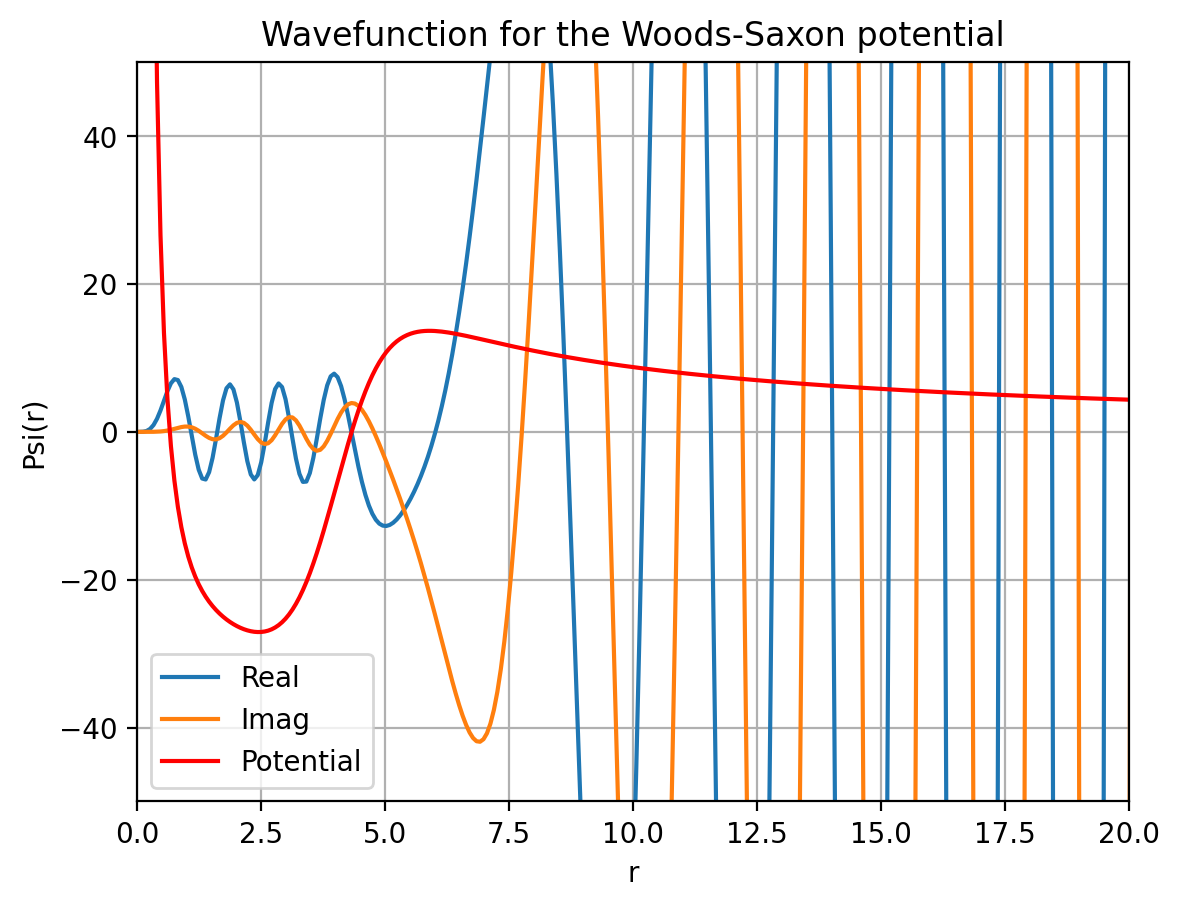

In [3]:
# Constants
Z1=1
Z2=60

eta=Z1*Z2*1.439
m = 1/2  # Particle mass
hbar = 1  # Reduced Planck constant

# Potential parameters
V0 = 60  # Potential strength
R = 4  # Woods-Saxon potential radius
a = 0.5  # Woods-Saxon potential diffuseness

# Energy and angular momentum quantum number
E = 13.4 - 1.3*1j  # Energy eigenvalue
l = 3   # Angular momentum quantum number


# Integration parameters
r_start = 0.05  # Initial position
r_end=70  # Final position

corr_factor=10

# Initial conditions
psi0 = corr_factor*r_start**(l+1) + 0j # Initial wavefunction value
psi_prime0 = corr_factor*(l+1)*r_start**(l) +0j # Initial derivative value

# Solve the Schrödinger equation
sol = solve_ivp(lambda r, y: schrodinger_eqn(r, y, E, V0, R, a, l), (r_start, r_end), [psi0, psi_prime0], dense_output=True)

# Calculate the wavefunction
r_values = np.linspace(r_start, r_end, 1000)
psi_values = sol.sol(r_values)[0]

potvals=(2 * m / hbar**2) * (woods_saxon_potential(r_values, V0, R, a) + l * (l + 1) / r_values**2 + coulomb_pot_list(Z1,Z2,r_values,R))

# Plot the wavefunction
# plt.plot(r_values, 10*np.real(psi_values)/max(abs(psi_values[800:-1])))
# plt.plot(r_values, 10*np.imag(psi_values)/max(abs(psi_values[800:-1])))

fig = plt.figure(dpi=200)
plt.plot(r_values, 10*np.real(psi_values),label='Real')
plt.plot(r_values, 10*np.imag(psi_values),label='Imag')
plt.plot(r_values, potvals,'r',label='Potential')

# plt.plot(r_values, coulomb_pot_list(Z1,Z2,r_values,R),'g')

plt.ylim(-50,50)
plt.xlim(0,20)

plt.legend()

plt.xlabel('r')
plt.ylabel('Psi(r)')
plt.title('Wavefunction for the Woods-Saxon potential')
plt.grid(True)
plt.show()


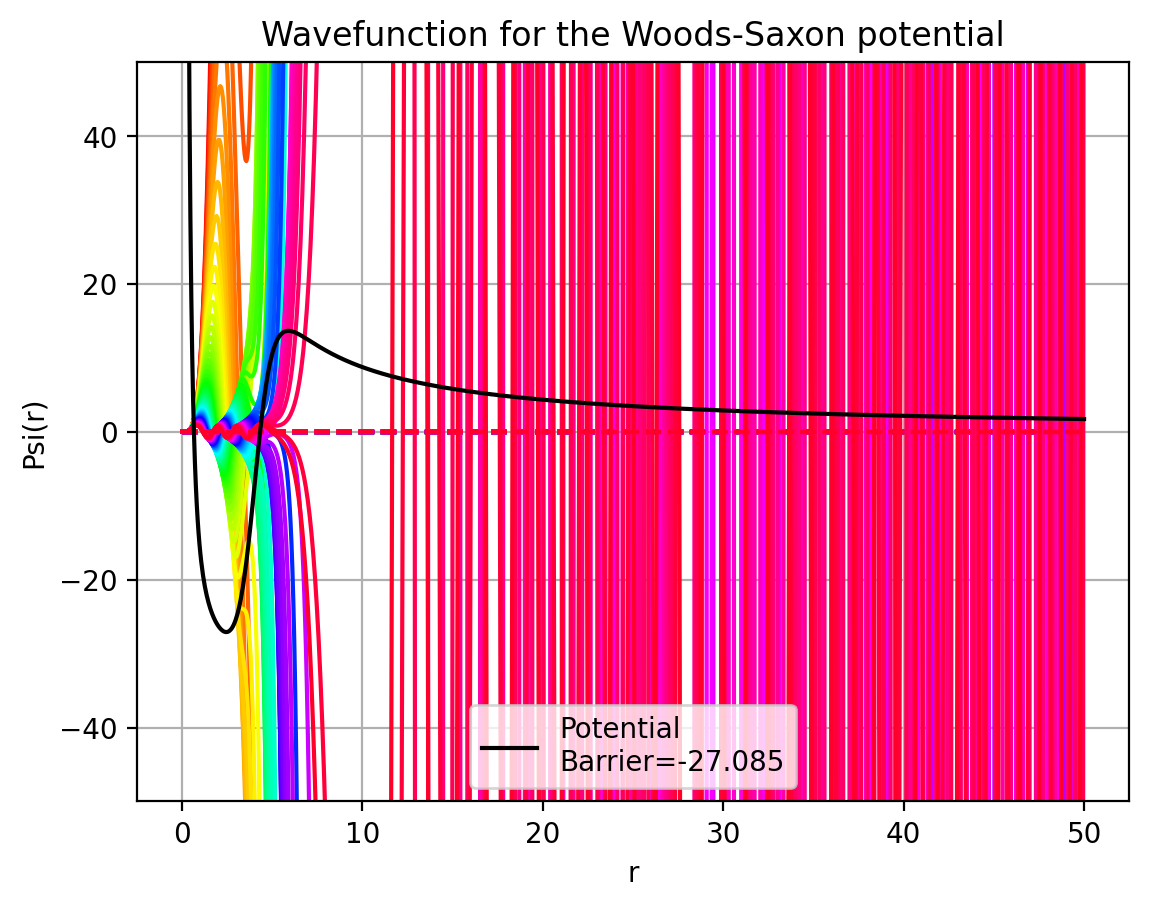

In [4]:
# Constants
Z1=1
Z2=60

eta=Z1*Z2*1.439
m = 1/2  # Particle mass
hbar = 1  # Reduced Planck constant

# Potential parameters
V0 = 60  # Potential strength
R = 4  # Woods-Saxon potential radius
a = 0.5  # Woods-Saxon potential diffuseness

# Energy and angular momentum quantum number
E = 13.4 - 1.3*1j  # Energy eigenvalue
l = 3   # Angular momentum quantum number


# Integration parameters
r_start = 0.01  # Initial position
r_end=50  # Final position

corr_factor=1

# Initial conditions
psi0 = corr_factor*r_start**(l+1) + 0j # Initial wavefunction value
psi_prime0 = corr_factor*(l+1)*r_start**(l) +0j # Initial derivative value

E = np.arange(-27,10,0.5)

fig = plt.figure(dpi=200)
cmap = cm.hsv

for i,e_ in enumerate(E):
    # Solve the Schrödinger equation
    sol = solve_ivp(lambda r, y: schrodinger_eqn(r, y, e_, V0, R, a, l), (r_start, r_end), [psi0, psi_prime0], dense_output=True)

    # Calculate the wavefunction
    r_values = np.linspace(r_start, r_end, 1000)
    psi_values = sol.sol(r_values)[0]

    potvals=(2 * m / hbar**2) * (woods_saxon_potential(r_values, V0, R, a) + l * (l + 1) / r_values**2 + coulomb_pot_list(Z1,Z2,r_values,R))

    # Plot the wavefunction
    # plt.plot(r_values, 10*np.real(psi_values)/max(abs(psi_values[800:-1])))
    # plt.plot(r_values, 10*np.imag(psi_values)/max(abs(psi_values[800:-1])))
    
    plt.plot(r_values, 10*np.real(psi_values),color=cmap(i/len(E)))
    plt.plot(r_values, 10*np.imag(psi_values),color=cmap(i/len(E)),linestyle='--')
plt.plot(r_values, potvals,label='Potential\nBarrier={:.3f}'.format(min(potvals)),color='k')

# plt.plot(r_values, coulomb_pot_list(Z1,Z2,r_values,R),'g')

plt.ylim(-50,50)
# plt.xlim(0,20)

plt.legend()

plt.xlabel('r')
plt.ylabel('Psi(r)')
plt.title('Wavefunction for the Woods-Saxon potential')
plt.grid(True)
plt.show()

# Finite-Difference Method made by Josh Wylie

We will be solving the following equation (where $V(r)$ corresponds to any extra potential aside from the centrifugal term):
\begin{equation}
    -\frac{\hbar^2}{2 m} \frac{d^2}{d r^2} u(r)+\left(V(r)+\frac{l(l+1)}{r^2} \frac{\hbar^2}{2 m}\right) u(r)=E u(r) .
\end{equation}
For any second derivative, we can approximate it for a finite step size as
\begin{equation}
    f^{\prime \prime}=\frac{f(x+h)-2 f(x)+f(x-h)}{h^2}+O\left(h^2\right)
\end{equation}
where $h$ denotes our step size - or in other words $h=(R_{\rm max} - R_{\rm min})/N_{\rm steps}$. Any arbitrary position $r_i$ can be expressed as the discrete step $r_i = R_{\rm min} + ih$ and we can simplify our notation above to a more programatic format such as $f(x_i+h)=f_{x_i+h}$ or in our case $u(r_i)=u_{r_i}$ to give our Schr\"odinger equation as
\begin{equation}
    -\frac{\hbar^2}{2 m} \frac{u_{k+1}-2 u_k+u_{k-1}}{h^2}+ \left(V_k+\frac{l(l+1)}{r_k^2} \frac{\hbar^2}{2 m}\right) u_k=  E u_k
\end{equation}

It might not be immediately obvious what to do from here, but that's okay! All we might be able to see right now is that if we were to program this, we would want to iterate over our position at each $k$ value. This is in fact what we'll do by building a matrix ranging the discretized points, but we will need to be careful of the $k\pm1$ subscripts as if we were to start at our minimum ($k=0$) or maximum ($k=N_{\rm steps}$) we would need to call $k=-1$ or $k=N_{\rm steps}+1$ which would be out-of-bounds.

Instead what we'll do is only consider indices from $k=1,N_{\rm steps}-1$ to avoid these edge cases. You may be wondering how we will address the two end points, and the answer is that this is conviniently where we introduce our boundary conditions! If we want Dirchlet conditions, then $u_{k=0}=u_{k=N_{\rm steps}}=0$ to force our wave function to be zero at both endpoints. This is only valid for cases where we would want such behavior, and the most common condition would be for a system with infinite walls in the potential.

\begin{equation}
    \left(\begin{array}{ccccccc}
    \frac{\hbar^2}{2 m}\frac{2}{h^2}+V'_1   & -\frac{\hbar^2}{2 m}\frac{1}{h^2}    & 0                 & 0                 & \ldots    & 0                                     & 0 \\
    -\frac{\hbar^2}{2 m}\frac{1}{h^2}      & \frac{\hbar^2}{2 m}\frac{2}{h^2}+V'_2 & -\frac{\hbar^2}{2 m}\frac{1}{h^2}    & 0                 & \cdots    & 0                                     & 0 \\
    0                   & -\frac{1}{h^2}    & -\frac{\hbar^2}{2 m}\frac{2}{h^2}+V'_3 & \frac{\hbar^2}{2 m}\frac{1}{h^2}    & 0         & \cdots                                & 0 \\
    \cdots              & \cdots            & \cdots            & \cdots            & \cdots    & \cdots                                & \cdots \\
    0                   & \cdots            & \cdots            & \cdots            & \cdots    & \frac{\hbar^2}{2 m}\frac{2}{h^2}+V'_{N_{\text {step }}-2} & -\frac{\hbar^2}{2 m}\frac{1}{h^2} \\
    0                   & \cdots            & \cdots            & \cdots            & \cdots    & -\frac{\hbar^2}{2 m}\frac{1}{h^2}                        & \frac{\hbar^2}{2 m}\frac{2}{h^2}+V'_{N_{\text {step }}-1}
    \end{array}\right)
\end{equation}

We'll simplify this by making two vectors, a diagonal and offdiagonal, to simplify our calculations since we only have a tridiagonal matrix with duplicate off diagonals. Note, $V'=V_k+\frac{l(l+1)}{r_k^2} \frac{\hbar^2}{2 m}$ is our reduced potential term.

#### Define some functions that are helpful for our full solution

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import diags # For creating the tridiagonal matrix

import matplotlib.cm as cm # Color map

In [5]:
class potentials:
    def __init__(self):
        self.e2 = 1.439646
        self.hbar = 6.582119E-22

    def WS(self,r,R,a,V0):
        return V0 * 1/(1+np.exp((r-R)/a))
    
    def SO(self,r,R,a,VSO):
        '''Returns the Spin-Orbit Potential (without the l \dot s coupling to be added later)'''
        derivativePart = (-1/a) * np.exp((r-R)/a) / (1+np.exp((r-R)/a))**2
        return VSO * derivativePart / r
    
    def Coulomb(self,r,rcutoff,z):
        coul = np.zeros(len(r))
        
        for i, rval in enumerate(r):
            if rval <= rcutoff:
                coul[i] = (z*self.e2/(2*rcutoff))*(3- (r[i]/rcutoff)**2)
            else:
                coul[i] = z*self.e2/(r[i])
        return coul
    
    def centrifugal(self,r,l,hbar22m):
        return hbar22m * l*(l+1)/(r**2)
    
    def HO(self,const,x):
        return 0.5 * const * (x**2)
    
    def calcV(self,params_,t_z_,j_,l_):
        Emax = params_['hbar22m'] * params_['kmax']**2
        A = params_['n'] + params_['z']
        r0A = params_['r0'] * A**(1/3)
        r_ = np.arange(0,params_['rmax'],params_['dr'])
        r_[0] = 10**-3

        # We can also precompute the non-\ell and non-j dependent terms of our potential for both nucleon types
        # pot = potentials()

        if t_z_ == 0:
            preCompV = self.WS(r_,r0A,params_['a'],params_['v0n'])
        else:
            preCompV = self.WS(r_,r0A,params_['a'],params_['v0p']) + pot.Coulomb(r_,params_['rcut'],params_['z'])

        # Compute the rest of the potential for \ell and j dependent terms, add that onto our precomputed V
        V = preCompV + self.SO(r_,r0A,params_['a'],params_['vso'])* (params_['r0']**2) * (j_*(j_+1) - l_*(l_+1) - 0.75) + self.centrifugal(r_,l_,params_['hbar22m'])
        return V

In [6]:
# Calculation functions!
def diag(V_,hbar22m_,N_step_,h_):
    return hbar22m_ * (2 / (h_**2))*np.ones(N_step_) + V_

def offdiag(hbar22m_,N_step_,h_):
    return (-hbar22m_ / (h_**2)) * np.ones(N_step_)

def V0calcStates(param_,extraFolder=''):
    Emax = param_['hbar22m'] * param_['kmax']**2
    A = param_['n'] + param_['z']
    r0A = param_['r0'] * A**(1/3)
    r = np.arange(0,param_['rmax'],param_['dr'])
    r[0] = 10**-3
    Nmax = len(r)
    spins = [-0.5,0.5]

    # Since all offdiagonals are independent of \ell, j, etc. we can precompute it
    offd = offdiag(param_['hbar22m'],Nmax-3,param_['dr']) # Off-diagonal array

    # We can also precompute the non-\ell and non-j dependent terms of our potential for both nucleon types
    pot = potentials()

    for t_z in range(2):
        if param_['neutron only'] == True and t_z == 1:
            break
        # For t_z = 0 we have neutrons and t_z = 1 we have protons (this takes care of 0 or 1 coulomb term)
        if t_z == 0:
            preCompV = pot.WS(r,r0A,param_['a'],param_['v0n'])
        else:
            preCompV = pot.WS(r,r0A,param_['a'],param_['v0p']) + t_z * pot.Coulomb(r,param_['rcut'],z)

        for l in range(param_['lmin'],param_['lmax']+1,1):
            for s in spins:
                # Skip iteration corresponding to second j=0.5 case
                if l == 0 and s==-0.5:
                    continue

                j = l + s
                
                # Compute the rest of the potential for \ell and j dependent terms, add that onto our precomputed V
                V = preCompV + pot.SO(r,r0A,param_['a'],param_['vso'])* (param_['r0']**2) * (j*(j+1) - l*(l+1) - 0.75) + pot.centrifugal(r,l,param_['hbar22m'])

                d = diag(V[1:-1],param_['hbar22m'],Nmax-2,param_['dr']) # Diagonal array

                # Generate our tridiagonal Hamiltonian
                tridiag = [offd, d, offd]
                offset = [-1,0,1]
                H = diags(tridiag,offset).toarray()

                # Find the eigenvalues and eigenvectors of our Hamiltonian where wf[:,i] corresponds to the i-th wave function
                E, wf = np.linalg.eig(H)

                # REMEMBER TO COMMENT OUT!!!!
                # print('my Es ',E[np.argsort(E)])
                # plt.plot(r,V)
                # plt.ylim(-40,30)
                # plt.show()

                # Filter Energies and their corresponding wave functions
                validEs = np.where(((E <= Emax)))[0]
                reducedE = E[validEs]
                reducedWF = wf[:,validEs]

                # Sort Energies and their corresponding wave functions
                reducedEsortIndices = np.argsort(reducedE)
                sortedReducedE = reducedE[reducedEsortIndices]
                sortedReducedWF = reducedWF[:,reducedEsortIndices]

                # Write energies to file ending in .ene
                with open(extraFolder+'tz_{:.0f}_j_{:.1f}_l_{:.0f}_V0_{}_r0_{}_a_{}_rmax_{}_dr_{}.ene'.format(t_z,j,l,param_['v0n'],param_['r0'],param_['a'],param_['rmax'],param_['dr']),'w') as f:
                    # Header
                    line = ''
                    for i in range(len(sortedReducedE)):
                        if i == (len(sortedReducedE) - 1):
                            line = line + 'n={}'.format(i) + '\n'
                        else:
                            line = line + 'n={}'.format(i) + ' '
                    f.write(line)
                    
                    # Write all energies
                    line = ''
                    for i in range(len(sortedReducedE)):
                        if i == (len(sortedReducedE) - 1):
                            line = line + str(sortedReducedE[i]) + '\n'
                        else:
                            line = line + str(sortedReducedE[i]) + ' '
                    f.write(line)

                # Write wave function to file ending in .wfs
                with open(extraFolder+'tz_{:.0f}_j_{:.1f}_l_{:.0f}_V0_{}_r0_{}_a_{}_rmax_{}_dr_{}.wfs'.format(t_z,j,l,param_['v0n'],param_['r0'],param_['a'],param_['rmax'],param_['dr']),'w') as f:
                    # Header
                    line = 'r(fm) '
                    for i in range(len(sortedReducedE)):
                        if i == (len(sortedReducedE) - 1):
                            line = line + 'n={}'.format(i) + '\n'
                        else:
                            line = line + 'n={}'.format(i) + ' '
                    f.write(line)

                    for i in range(sortedReducedWF.shape[0]):
                        line = str(r[i+1]) + ' '
                        line = line + " ".join([str(w) for w in sortedReducedWF[i,:]])
                        f.write(line+'\n')
                
                print('tz={:.0f} j={:.1f} $\ell$={:.0f} Calculated'.format(t_z,j,l))


In [7]:
# Plotting functions!
def deriv(x2,x1,dx2,dx1):
    return (x2-x1)/(dx2-dx1)

def squareV0plotWFvariation(tz,n_,j_,l_,v0_check,param_,leg=True,extraFolder='',partialWave='$g_{7/2}$'):

    fig, ax = plt.subplots(2,2,figsize=[12,12])
    r = np.arange(0,param_['rmax'],param_['dr'])
    r[0] = 10**-12
    pot = potentials()
    r0A = param_['r0'] * (param_['n'] + param_['z'])**(1/3)

    cmap = cm.hsv
    tempEm1s = []
    tempV0m1 = []

    for i, tV0 in enumerate(v0_check):
        WFs = pd.read_csv(extraFolder+'tz_{}_j_{:.1f}_l_{}_V0_{}_dr_{}.wfs'.format(tz,j_,l_,tV0,param_['dr']),delim_whitespace=True)
        Es = pd.read_csv(extraFolder+'tz_{}_j_{:.1f}_l_{}_V0_{}_dr_{}.ene'.format(tz,j_,l_,tV0,param_['dr']),delim_whitespace=True)
        Eval = Es['n={}'.format(n_)].to_numpy()[0] # Get energy value
        # print(Eval)

        V = pot.WS(r,r0A,param_['a'],tV0) + pot.SO(r,r0A,param_['a'],param_['vso'])* (param_['r0']**2) * (j_*(j_+1) - l_*(l_+1) - 0.75) + pot.Coulomb(r,r0A,param_['z']) + pot.centrifugal(r,l_,param_['hbar22m'])
        if i % 10 == 0:
            ax[0,0].plot(r,V,color=cmap(i/len(v0_check)),label='V_0={:.3f} and E={:.3f}'.format(tV0,Eval))
            ax[0,0].axhline(Eval,color=cmap(i/len(v0_check)))
        else:
            ax[0,0].plot(r,V,color=cmap(i/len(v0_check)))

        # ax[1,0].plot(WFs['r(fm)'],np.abs(WFs['n={}'.format(n_)]),color=cmap(i/len(v0_check))) # Absolute Value WF
        # ax[1,0].plot(WFs['r(fm)'],np.abs(WFs['n={}'.format(n_)]) / (WFs['r(fm)']),color=cmap(i/len(v0_check))) # Absolute Value WF, rescaled by 1/(4*pi*r)
        ax[1,0].plot(WFs['r(fm)'],(WFs['n={}'.format(n_)]),color=cmap(i/len(v0_check))) # Regular WF

        ax[0,1].scatter(tV0,Eval,color=cmap(i/len(v0_check)))

        tempEm1s.append(Eval)
        tempV0m1.append(tV0)

        if i > 0:
            # Plot Derivative
            ax[1,1].scatter(tempV0m1[-1],deriv(tempEm1s[-1],tempEm1s[-2],tempV0m1[-1],tempV0m1[-2]),color=cmap(i/len(v0_check)))
    
    # ax[2].plot(tempV0,tempEs)

    ax[0,0].set_ylabel(partialWave+' Total Potential (MeV)')
    ax[0,0].set_xlabel('$r$ (fm)')
    ax[0,0].set_ylim(-45,30)

    ax[1,0].set_ylabel(str(n_)+partialWave+' Wave Function (Absolute Value)')
    ax[1,0].set_xlabel('$r$ (fm)')

    ax[0,1].set_ylabel(str(n_)+partialWave+' Energy (MeV)')
    ax[0,1].set_xlabel('$V_0$ (MeV)')

    ax[1,1].set_ylabel('$\\frac{d}{dV_0}$'+str(n_)+partialWave+' Energy (MeV)')
    ax[1,1].set_xlabel('$V_0$ (MeV)')

    ax[0,0].legend(fontsize=6)
    # ax[1].legend(fontsize=6)

    fig.tight_layout()
    plt.savefig('swf_plot_tz_{}_n_{}_j_{:.1f}_l_{}_v01_{}_v02_{}_rmax_{}_dr_{}.pdf'.format(tz,n_,j_,l_,v0_check[0],v0_check[-1],param_['rmax'],param_['dr']))
    plt.show()

## Checking for neutron bound states in $^{48}$ Ca

In [8]:
# Calculations

# If you'd like to store output files in a specific folder, set the folder info here!
folder = 'test/'

# Range of potentials if desired and the iteration step size
v01, v02 = -45.5,-45.5
v0step = 1
v0Array = np.linspace(v01,v02,int((v02-v01)/v0step+1))
print(v0Array)

# Set the default parameters you'd like to perform calculations with
param = {'rmax':15,'dr':0.01,'a':0.67,'r0':1.27,'rcut':0.84,'v0n':-45.5,'v0p':-45.5,'vso':19.6666666667,'n':28,'z':20,'hbar22m':20.735530,'kmax':4,'lmax':4,'lmin':0,'neutron only':True}

# Run over our desired parameters!
for iv0 in v0Array:
    print('Running at {}'.format(iv0))
    param['v0n'] = iv0
    V0calcStates(param,folder)

[-45.5]
Running at -45.5
tz=0 j=0.5 $\ell$=0 Calculated
tz=0 j=0.5 $\ell$=1 Calculated
tz=0 j=1.5 $\ell$=1 Calculated
tz=0 j=1.5 $\ell$=2 Calculated
tz=0 j=2.5 $\ell$=2 Calculated
tz=0 j=2.5 $\ell$=3 Calculated
tz=0 j=3.5 $\ell$=3 Calculated
tz=0 j=3.5 $\ell$=4 Calculated
tz=0 j=4.5 $\ell$=4 Calculated


In [9]:
# Printing bound/resonant states and their j,l values
spin = [-0.5,0.5]
for l in range(param['lmax']+1):
    for s in spin:
        if (s == -0.5) and (l==0):
            continue
        print('j = {:.1f}, l={}'.format(l+s,l))
        tempData = pd.read_csv(folder+'tz_{}_j_{:.1f}_l_{}_V0_{}_rmax_{}_dr_{}.ene'.format(0,l+s,l,v01,param['rmax'],param['dr']),delim_whitespace=True).to_numpy()[0]
        print(tempData[np.where(tempData < 5)])

j = 0.5, l=0


FileNotFoundError: [Errno 2] No such file or directory: 'test/tz_0_j_0.5_l_0_V0_-45.5_rmax_15_dr_0.01.ene'

Hopefully when you ran this with the parameters:

```param = {'rmax':15,'dr':0.01,'a':0.67,'r0':1.27,'rcut':0.84,'v0n':-45.5,'v0p':-45.5,'vso':19.6666666667,'n':28,'z':20,'hbar22m':20.735530,'kmax':4,'lmax':4,'lmin':0,'neutron only':True}```

you got the following energies (just doing bound states):

\begin{align}
    0s_{1/2}= & -35.014 \nonumber \\
    0p_{3/2}= & -27.379 \nonumber \\
    0p_{1/2}= & -23.451 \nonumber \\
    0d_{5/2}= & -19.421 \nonumber \\
    1s_{1/2}= & -14.251 \nonumber \\
    0d_{3/2}= & -11.199 \nonumber \\
    0f_{7/2}= & -11.168 \nonumber \\
    1p_{3/2}= & -5.679 \nonumber \\
    0g_{11/2}= & -2.621 \nonumber \\
    1p_{1/2}= & -1.950.
\end{align}

If you got this, everything is working correctly!

## Starting our RBM process

As another reminder, we're solving the following problem:
\begin{equation}
    \left(-\frac{\hbar^2}{2 m} \frac{d^2}{d r^2} +V(r)+\frac{l(l+1)}{r^2} \frac{\hbar^2}{2 m}\right) u(r)=E u(r) .
\end{equation}
If we wanted to follow some of the familiar formalism, we can rewrite everything to
\begin{equation}
    \left(-\frac{d^2}{d r^2} +\frac{2m}{\hbar^2}V(r)+\frac{l(l+1)}{r^2} -\frac{2m}{\hbar^2}E\right) u(r)=0 .
\end{equation}

Which we then can formulate into the RBM notation that was used in other examples where we'll have our vectors (functions) $u(r)\rightarrow\phi$ and takes the general form $F_\alpha(\phi_\alpha)=0$. In our case, our possible parameter values $\alpha$ can be any of the parameters of our potential $V'(r)$ (which includes the centrifugal term).

If you've read other RBM papers or notebooks, this may be redundant, but its helpful to reemphasize that our goal is to find approximate solutions $\hat{\phi_\alpha}$ to our problem such that
\begin{equation}
    \hat{\phi_\alpha} = \phi_0 + \sum_{k=1}^n a_k \phi_k
\end{equation}
with $a_k$ being coefficients of our approximation that are dependent on our selected values of $\alpha$ - with basis functions $\phi_k$ remaining independent on $\alpha$.

Our selection of reduced-basis-$\phi$'s can be done different ways, but we can just start by running calculations for a set of $n$ parameters $\alpha$ i.e. $\left\{\alpha_1, \alpha_2,..., \alpha_n\right\}$. For each parameter set $\alpha_i$ we will be able to calculate the eigenvectors of our Hamiltonian which can serve as our basis vectors for one solution.

For our example, our potential is
\begin{align}
    V'(r)&=\frac{2m}{\hbar^2}V(r)+\frac{\ell(\ell+1)}{r^2} \\
    &=\frac{2m}{\hbar^2}\left[V_{WS}+\left(j(j+1)-\ell(\ell+1)-0.75\right)V_{SO}(r)+V_{COUL}\right]+\frac{\ell(\ell+1)}{r^2}
\end{align}

\begin{equation}
    V_{WS}=\frac{V_0}{1+\exp\left(\frac{r-r_0}{a}\right)},\quad V_{SO}=\frac{V_{0SO}}{r} \frac{d}{dr} \left(\frac{1}{1+\exp\left(\frac{r-r_0}{a}\right)}\right)
\end{equation}

\begin{equation}
    V_{COUL}=...
\end{equation}
and the coefficients we can modify are $V_0, V_{0SO}, a,r_0$. While all are certainly important, we can simply focus on changing a subset, let's say just the Woods-Saxon parameters.

In [10]:
# We'll want to loop over different values of V0, r0, and a
alphas = np.array([[-45.5,1.27,0.67],
                   [-45.5,2.54,1.34],
                   [-35.5,1.0,0.25],
                   [-60.0,1.65,0.9]])

# If you'd like to store output files in a specific folder, set the folder info here!
folder = 'test/'

# Run over our desired parameters!
for alph in alphas:
    # Set the default parameters you'd like to perform calculations with
    param = {'rmax':15,'dr':0.01,'a':alph[2],'r0':alph[1],'rcut':0.84,'v0n':alph[0],
             'v0p':-45.5,'vso':19.6666666667,'n':28,'z':20,'hbar22m':20.735530,
             'kmax':4,'lmax':4,'lmin':0,'neutron only':True}
    print('Running at v0={}, r0={}, a={}'.format(alph[0],alph[1],alph[2]))
    V0calcStates(param,folder)

Running at v0=-45.5, r0=1.27, a=0.67
tz=0 j=0.5 $\ell$=0 Calculated
tz=0 j=0.5 $\ell$=1 Calculated
tz=0 j=1.5 $\ell$=1 Calculated
tz=0 j=1.5 $\ell$=2 Calculated
tz=0 j=2.5 $\ell$=2 Calculated
tz=0 j=2.5 $\ell$=3 Calculated
tz=0 j=3.5 $\ell$=3 Calculated
tz=0 j=3.5 $\ell$=4 Calculated
tz=0 j=4.5 $\ell$=4 Calculated
Running at v0=-45.5, r0=2.54, a=1.34
tz=0 j=0.5 $\ell$=0 Calculated
tz=0 j=0.5 $\ell$=1 Calculated
tz=0 j=1.5 $\ell$=1 Calculated
tz=0 j=1.5 $\ell$=2 Calculated
tz=0 j=2.5 $\ell$=2 Calculated
tz=0 j=2.5 $\ell$=3 Calculated
tz=0 j=3.5 $\ell$=3 Calculated
tz=0 j=3.5 $\ell$=4 Calculated
tz=0 j=4.5 $\ell$=4 Calculated
Running at v0=-35.5, r0=1.0, a=0.25
tz=0 j=0.5 $\ell$=0 Calculated
tz=0 j=0.5 $\ell$=1 Calculated
tz=0 j=1.5 $\ell$=1 Calculated
tz=0 j=1.5 $\ell$=2 Calculated
tz=0 j=2.5 $\ell$=2 Calculated
tz=0 j=2.5 $\ell$=3 Calculated
tz=0 j=3.5 $\ell$=3 Calculated
tz=0 j=3.5 $\ell$=4 Calculated
tz=0 j=4.5 $\ell$=4 Calculated
Running at v0=-60.0, r0=1.65, a=0.9
tz=0 j=0.5 $\ell$

(-60.0, 30.0)

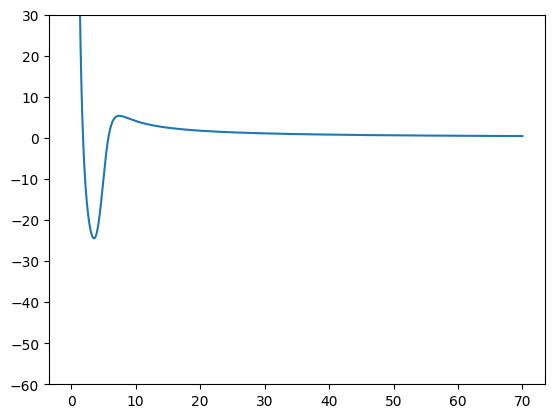

In [28]:
# Potential parameters
V0 = -45.5  # Potential strength
VSO = 19.6666667
r0 = 1.27  # Woods-Saxon potential radius
a = 0.65  # Woods-Saxon potential diffuseness

# Energy and angular momentum quantum number
l = 2   # Angular momentum quantum number
j = 2.5

n = 28
z = 20

rcut = 1.27
hbar22m = 20.73553

pot = potentials()
r_values = np.linspace(r_start, r_end, 1000)
potvals= pot.calcV(r_values,j,l,n,z,r0,a,rcut,V0,VSO,hbar22m)

plt.plot(r_values,potvals)
plt.ylim(-60,30)

(-60.0, 30.0)

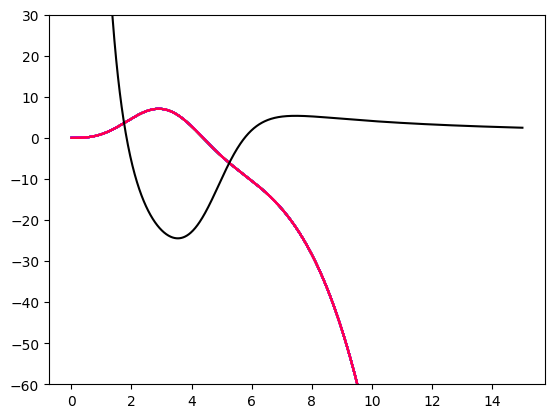

In [35]:
#Rest of the smart code goes here...
def highFidelity(E, V0, VSO, r0, a, l,j, r_start, r_end, psi0, psi_prime0,n=28,z=20,rcut=1.27,hbar22m=20.73553):
    pot = potentials()
    # Solve the Schrödinger equation 
    sol = solve_ivp(lambda r, y: pot.schrodinger_eqn(r, y, E, j,l,n,z,r0,a,rcut,V0,VSO,hbar22m,Z2=20,Z1=1), (r_start, r_end), [psi0, psi_prime0], dense_output=True)

    # Calculate the wavefunction
    r_values = np.linspace(r_start, r_end, 1000)
    psi_values = sol.sol(r_values)[0]

    potvals= pot.calcV(r_values,j,l,n,z,r0,a,rcut,V0,VSO,hbar22m)
    return r_values, psi_values, potvals

# Constants
Z1=1
Z2=20

eta=Z1*Z2*1.439
m = 1/2  # Particle mass
hbar = 1  # Reduced Planck constant

# Potential parameters
V0 = -45.5  # Potential strength
VSO = 19.6666667
R = 1.27  # Woods-Saxon potential radius
a = 0.65  # Woods-Saxon potential diffuseness

# Energy and angular momentum quantum number
E = -20 - 0*1j  # Energy eigenvalue
l = 2   # Angular momentum quantum number
j = 2.5


# Integration parameters
r_start = 0.01  # Initial position
r_end=15  # Final position

corr_factor=1

# Initial conditions
psi0 = corr_factor*r_start**(l+1) + 0j # Initial wavefunction value
psi_prime0 = corr_factor*(l+1)*r_start**(l) +0j # Initial derivative value

E = np.arange(-30,0,1)
cmap = cm.hsv

for i,e_ in enumerate(E):
    r_values, psi_values, potvals = highFidelity(e_, V0,VSO, R, a, l,j, r_start, r_end, psi0, psi_prime0)
    plt.plot(r_values,np.real(psi_values),color=cmap(i/len(E)))


plt.plot(r_values,potvals,color='k')
plt.ylim(-60,30)